In [1]:
!pip install colpali_engine==0.1.1

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 11.7 MB/s eta 0:00:00
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=c64e6b7ea86072b84d9139324baf13c022cb8b229a604559eca7cd52e6f8396f
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [2]:
!pip install "colpali-engine[train]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.2/32.2 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: polars
    Found

In [3]:
!pip install pdf2image

In [5]:
import torch
import typer
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoProcessor
from PIL import Image
from typing import List, Tuple, Union

In [6]:
from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator
from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
from colpali_engine.utils.image_from_page_utils import load_from_dataset

In [7]:
from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator

In [8]:
from pdf2image import convert_from_path

In [9]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (215 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123597 

In [10]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 35.0 MB/s eta 0:00:00


In [11]:
from IPython.display import display

In [52]:
import torch
from typing import List, Union, Tuple
from PIL import Image
import faiss
import numpy as np

MOCK_IMAGE = Image.new("RGB", (448, 448), (255, 255, 255))


def load_model(model_name: str = "vidore/colpaligemma-3b-mix-448-base") -> Tuple[ColPali, AutoProcessor]:
    """Load ColPali model and processor."""
    model = ColPali.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda").eval()
    processor = AutoProcessor.from_pretrained(model_name)
    return model, processor


def process_documents(documents: List[Union[str, Image.Image]], processor: AutoProcessor, model: ColPali) -> np.ndarray:
    """Process documents and get embeddings as a 2D NumPy array (n_documents, embedding_dim)."""
    dataloader = DataLoader(
        documents,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: process_images(processor, x)
    )
    document_embeddings = []
    for batch in tqdm(dataloader):
        with torch.no_grad():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            embeddings = model(**batch)
        # Unbind the embeddings and convert to CPU before appending to the list
        document_embeddings.extend(list(torch.unbind(embeddings.to("cpu"))))

    # Stack and convert to a 2D NumPy array
    document_embeddings = torch.stack(document_embeddings).float().cpu().numpy()

    # Reshape to ensure it’s 2D (n_documents, embedding_dim)
    if len(document_embeddings.shape) > 2:
        document_embeddings = document_embeddings.reshape(-1, document_embeddings.shape[-1])

    return document_embeddings


def process_queries_func(queries: List[str], processor: AutoProcessor, model: ColPali) -> np.ndarray:
    """Process queries and get embeddings as a 2D NumPy array (n_queries, embedding_dim)."""
    dataloader = DataLoader(
        queries,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: process_queries(processor, x, MOCK_IMAGE)
    )
    query_embeddings = []
    for batch in dataloader:
        with torch.no_grad():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            embeddings = model(**batch)
        # Unbind the embeddings and convert to CPU before appending to the list
        query_embeddings.extend(list(torch.unbind(embeddings.to("cpu"))))

    # Stack and convert to a 2D NumPy array
    query_embeddings = torch.stack(query_embeddings).float().cpu().numpy()

    # Reshape to ensure it’s 2D (n_queries, embedding_dim)
    if len(query_embeddings.shape) > 2:
        query_embeddings = query_embeddings.reshape(-1, query_embeddings.shape[-1])

    return query_embeddings



def evaluate_retrieval(query_embeddings: List[torch.Tensor], document_embeddings: np.ndarray, faiss_index: faiss.Index, top_k: int = 5) -> List[Tuple[List[int], List[float]]]:
    # Add document embeddings to the FAISS index (if not done earlier)
    if faiss_index.ntotal == 0:  # Check if the index is empty
        faiss_index.add(document_embeddings)

    # Perform search with FAISS (top_k is passed as the second positional argument)
    distances, indices = faiss_index.search(query_embeddings, top_k)

    return [(idx_list.tolist(), dist_list.tolist()) for idx_list, dist_list in zip(indices, distances)]



def process_documents_with_filenames(
    documents_with_filenames: List[Tuple[Image.Image, str]],
    processor: AutoProcessor,
    model: ColPali
) -> Tuple[List[torch.Tensor], List[str]]:
    """Process documents and return one embedding per page along with filenames."""

    images = [doc[0] for doc in documents_with_filenames]  # Extract the image objects
    filenames = [doc[1] for doc in documents_with_filenames]  # Extract the filenames

    dataloader = DataLoader(
        images,
        batch_size=4,
        shuffle=False,
        collate_fn=lambda x: process_images(processor, x)
    )

    document_embeddings = []
    expanded_filenames = []

    for batch in tqdm(dataloader):
        with torch.no_grad():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            embeddings = model(**batch)

        # Take the mean of embeddings across sequence length (dim 1) to ensure one embedding per page
        mean_embeddings = torch.mean(embeddings, dim=1).cpu()  # Average across the sequence dimension

        document_embeddings.extend(list(torch.unbind(mean_embeddings)))  # Unbind to get individual tensors
        expanded_filenames.extend(filenames[:len(mean_embeddings)])  # Add the filenames corresponding to the embeddings

    print(f"Embeddings added: {len(document_embeddings)}, Filenames added: {len(expanded_filenames)}")
    return document_embeddings, expanded_filenames




def convert_pdf_to_images(pdf_path: str) -> List[Image.Image]:
    """Convert a PDF into a list of images (one per page)."""
    try:
        images = convert_from_path(pdf_path)
        return images
    except Exception as e:
        print(f"Error converting PDF {pdf_path}: {e}")
        return []


def load_images_with_filenames_from_pdfs(pdf_paths: List[str]) -> List[Tuple[Image.Image, str]]:
    """Convert PDFs to images and return them with filenames."""
    images_with_filenames = []
    for pdf_path in pdf_paths:
        images = convert_pdf_to_images(pdf_path)
        for i, image in enumerate(images):
            image_filename = f"{pdf_path} - Page {i+1}"  # Label each page with the PDF name and page number
            images_with_filenames.append((image, image_filename))
    return images_with_filenames


import torch
import numpy as np
import faiss


def add_index(document_embeddings: np.ndarray) -> faiss.Index:
    """Create and add document embeddings to the FAISS index."""
    # Check the shape and flatten if necessary
    if len(document_embeddings.shape) > 2:
        # Flatten to 2D (e.g., batch size x embedding_dim)
        document_embeddings = document_embeddings.reshape(-1, document_embeddings.shape[-1])

    embedding_dim = document_embeddings.shape[-1]  # Embedding size
    faiss_index = faiss.IndexFlatL2(embedding_dim)

    print(f"Embeddings shape: {document_embeddings.shape}")
    print(f"FAISS index dimensionality: {faiss_index.d}")

    # Add embeddings to the FAISS index
    faiss_index.add(document_embeddings)

    return faiss_index

def generate_metadata(documents_with_filenames: List[Tuple[Image.Image, str]]) -> List[Dict[str, Union[str, int]]]:
    """Generate metadata for each document, e.g., document name and page number."""
    metadata_list = []
    for image, filename in documents_with_filenames:
        document_name, page_info = filename.split(' - Page ')
        page_number = int(page_info)
        metadata = {
            "document_name": document_name,
            "page_number": page_number,
        }
        metadata_list.append(metadata)
    return metadata_list


from IPython.display import display

def search(
    model,
    processor,
    documents_with_filenames: List[Tuple[Image.Image, str]],
    queries: List[str],
    top_k: int = 5
) -> None:
    """Search and retrieve documents based on queries, showing document names, pages, scores, and metadata."""

    document_embeddings, filenames = process_documents_with_filenames(documents_with_filenames, processor, model)

    metadata_list = generate_metadata(documents_with_filenames)

    query_embeddings = process_queries_func(queries, processor, model)

    # Step 3: Add document embeddings to FAISS index
    faiss_index, embed_id_to_metadata = add_index(document_embeddings, metadata_list)

    # Step 4: Evaluate retrieval using FAISS
    retrieval_results = evaluate_retrieval(query_embeddings, document_embeddings, faiss_index, top_k)

    # Step 5: Display top-k results with metadata
    for i, query in enumerate(queries):
        print(f"\nQuery: {query}")
        print(f"Top {top_k} results:")
        top_result_indices, top_result_distances = retrieval_results[i]

        for rank, (idx, dist) in enumerate(zip(top_result_indices, top_result_distances)):
            if idx >= len(filenames):
                print(f"Warning: Index {idx} is out of range for filenames. Skipping this result.")
                continue  # Skip invalid indices

            # Extract document name, page number, and metadata
            try:
                document_name, page_info = filenames[idx].split(' - Page ')
                metadata = metadata_list[idx]  # Retrieve metadata for this embedding
                print(f"Rank {rank + 1}: Document: {document_name}, Page: {page_info}, Distance: {dist:.4f}, Metadata: {metadata}")

                # Display the corresponding image for this document
                image = documents_with_filenames[idx][0]  # Get the image from the tuple
                display(image)  # Use IPython.display to show the image

            except Exception as e:
                print(f"Error splitting filename or retrieving metadata: {filenames[idx]} - {e}")
                continue


def add_index(document_embeddings: List[torch.Tensor], metadata_list: List[Dict[str, Union[str, int]]]) -> Tuple[faiss.Index, Dict[int, Dict[str, Union[str, int]]]]:
    """Create and add document embeddings to the FAISS index, along with metadata mapping."""

    # Stack and convert list of tensors into a NumPy array
    document_embeddings = torch.stack(document_embeddings).float().cpu().numpy()

    # Ensure the embeddings are 2D (n_documents, embedding_dim)
    document_embeddings = document_embeddings.reshape(-1, document_embeddings.shape[-1])

    embedding_dim = document_embeddings.shape[-1]  # Embedding size
    faiss_index = faiss.IndexFlatL2(embedding_dim)

    print(f"Embeddings shape: {document_embeddings.shape}")
    print(f"FAISS index dimensionality: {faiss_index.d}")

    # Add embeddings to the FAISS index
    faiss_index.add(document_embeddings)

    # Create a mapping from embedding index to metadata
    embed_id_to_metadata = {idx: metadata for idx, metadata in enumerate(metadata_list)}

    return faiss_index, embed_id_to_metadata


In [14]:
model, processor = load_model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of ColPali were not initialized from the model checkpoint at vidore/colpaligemma-3b-mix-448-base and are newly initialized: ['model.language_model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [33]:
pdf_paths = ["/content/groww-client-guidance.pdf"]


documents_with_filenames = load_images_with_filenames_from_pdfs(pdf_paths)

In [40]:
documents_with_filenames

[(<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
  '/content/groww-client-guidance.pdf - Page 1'),
 (<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
  '/content/groww-client-guidance.pdf - Page 2'),
 (<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
  '/content/groww-client-guidance.pdf - Page 3'),
 (<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
  '/content/groww-client-guidance.pdf - Page 4'),
 (<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
  '/content/groww-client-guidance.pdf - Page 5'),
 (<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
  '/content/groww-client-guidance.pdf - Page 6'),
 (<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
  '/content/groww-client-guidance.pdf - Page 7'),
 (<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>,
  '/content/groww-client-guidance.pdf - Page 8'),
 (<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339

100%|██████████| 5/5 [00:54<00:00, 10.91s/it]


Embeddings added: 17, Filenames added: 17
Embeddings shape: (17, 128)
FAISS index dimensionality: 128

Query: in case of termination of trading membership
Top 3 results:
Rank 1: Document: /content/groww-client-guidance.pdf, Page: 3, Distance: 2.5204, Metadata: {'document_name': '/content/groww-client-guidance.pdf', 'page_number': 11}


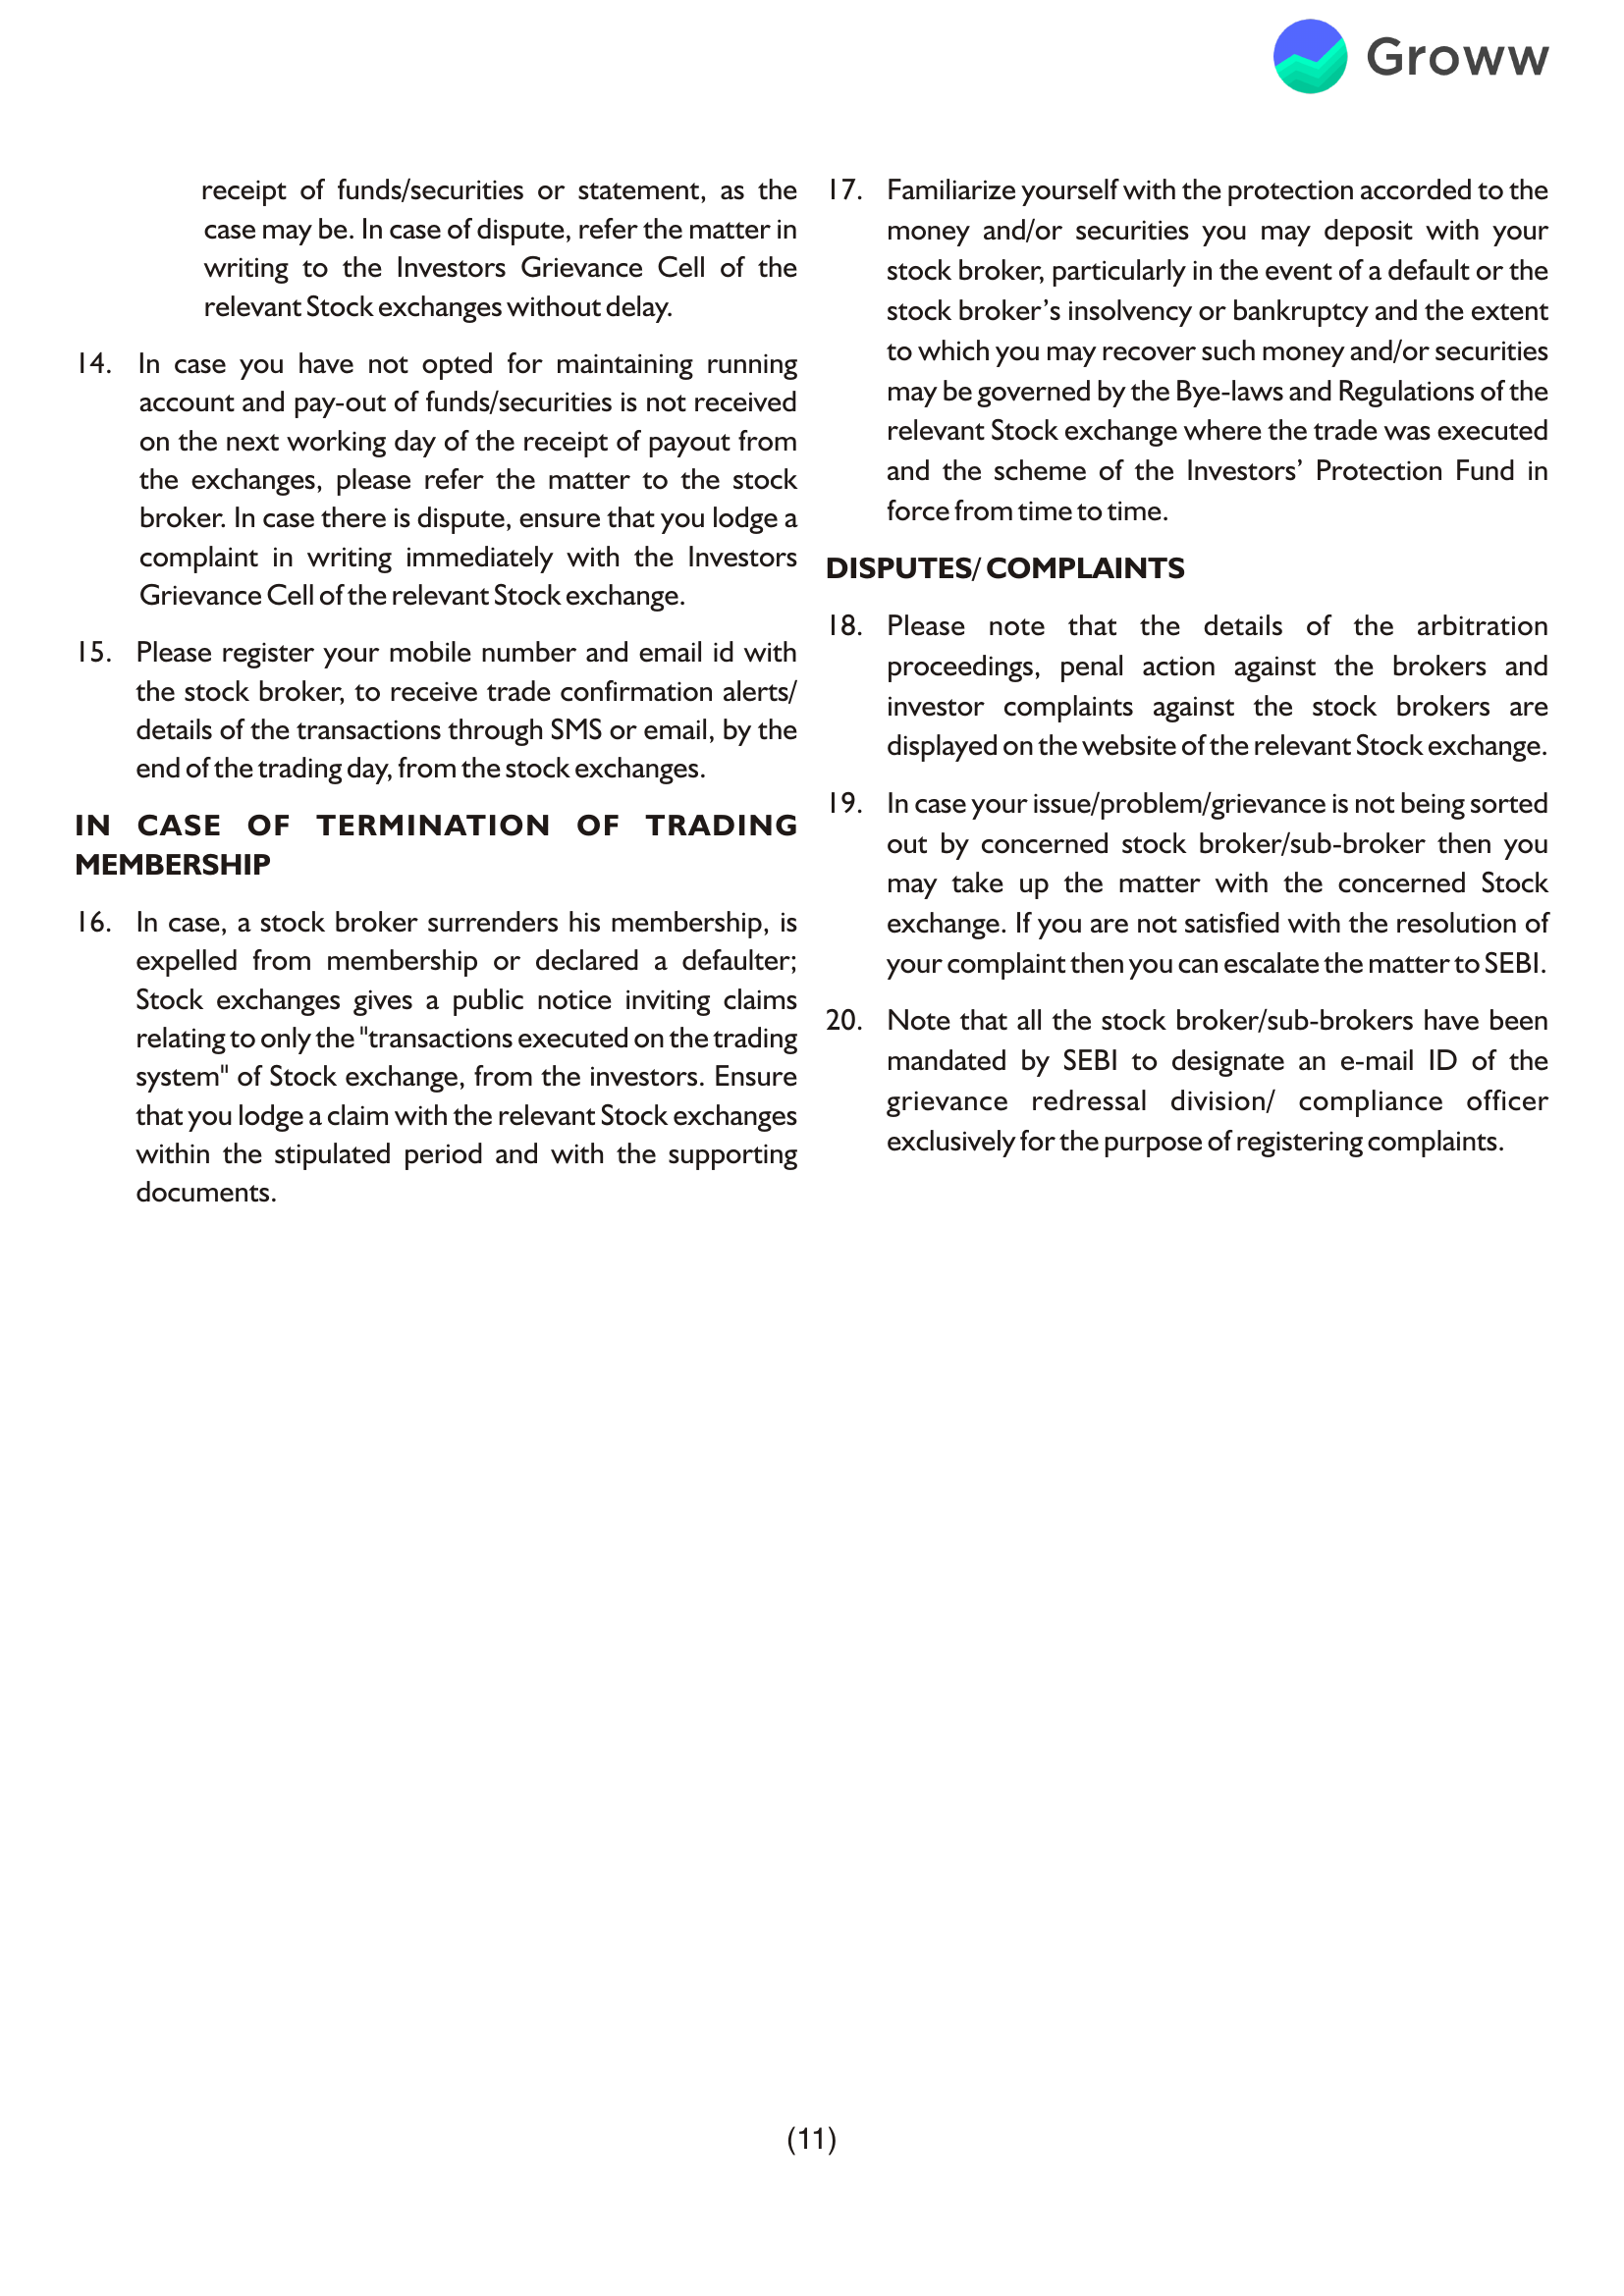

Rank 2: Document: /content/groww-client-guidance.pdf, Page: 1, Distance: 2.5469, Metadata: {'document_name': '/content/groww-client-guidance.pdf', 'page_number': 9}


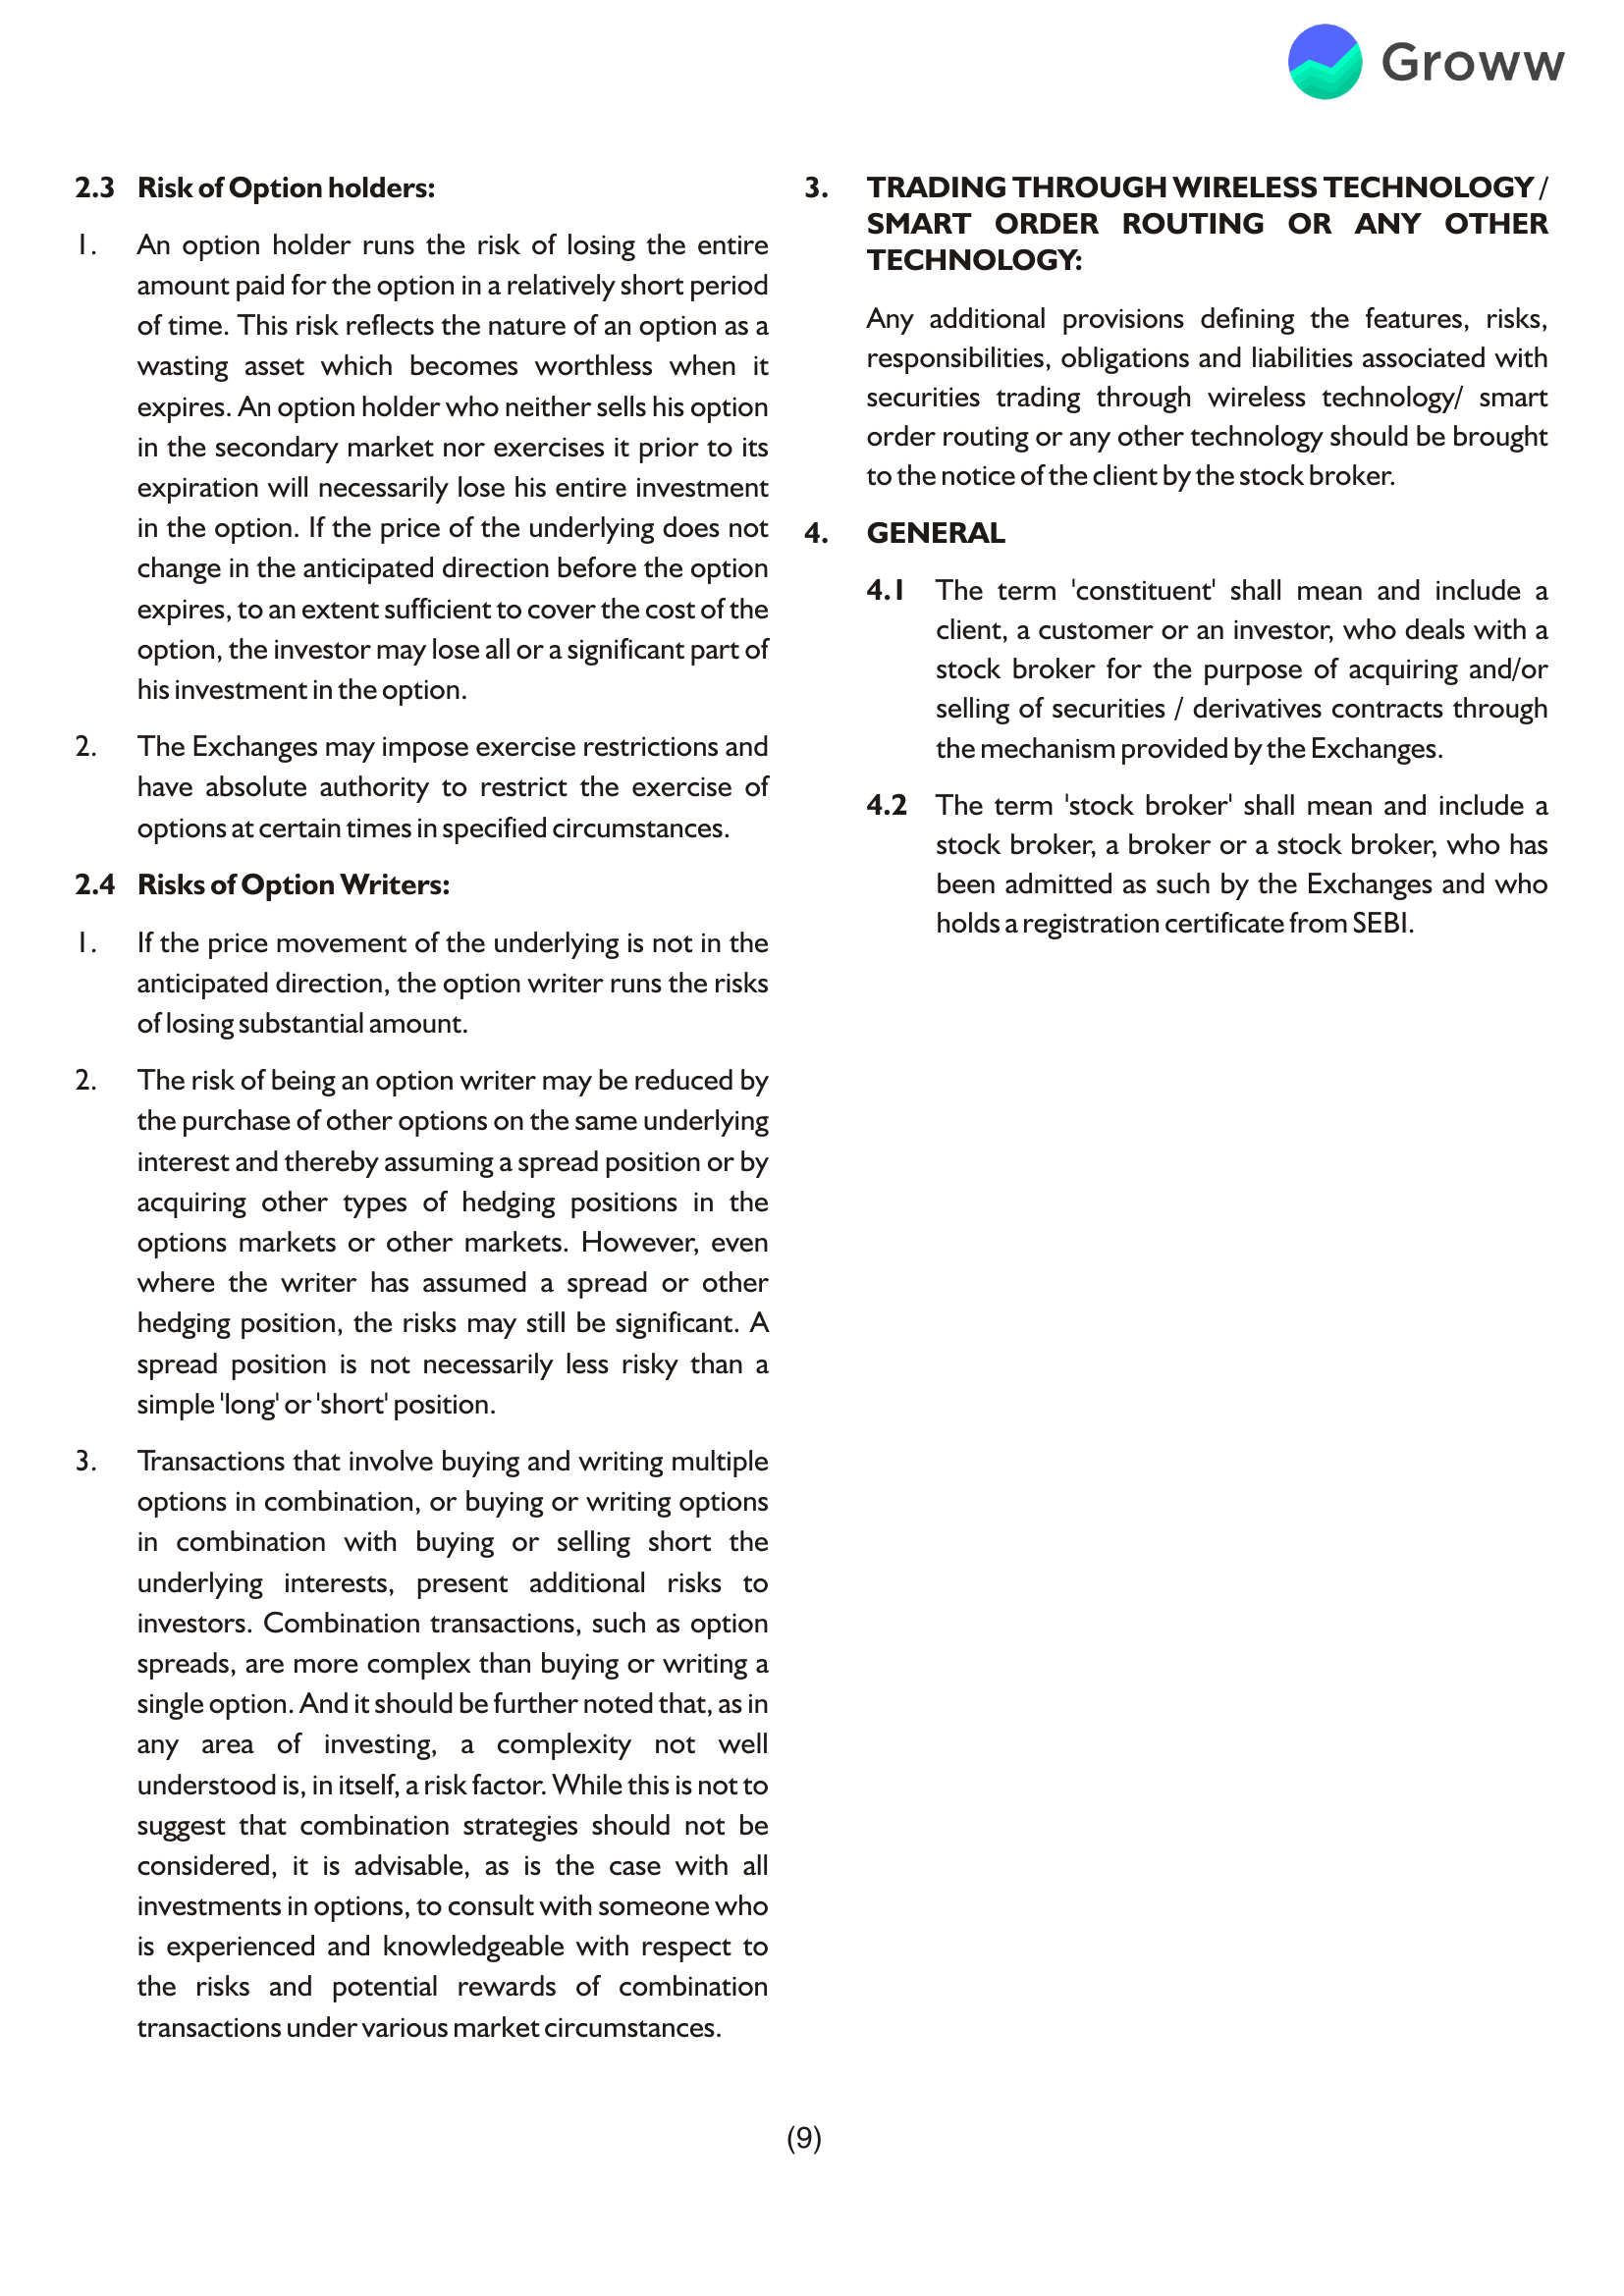

Rank 3: Document: /content/groww-client-guidance.pdf, Page: 4, Distance: 2.5503, Metadata: {'document_name': '/content/groww-client-guidance.pdf', 'page_number': 16}


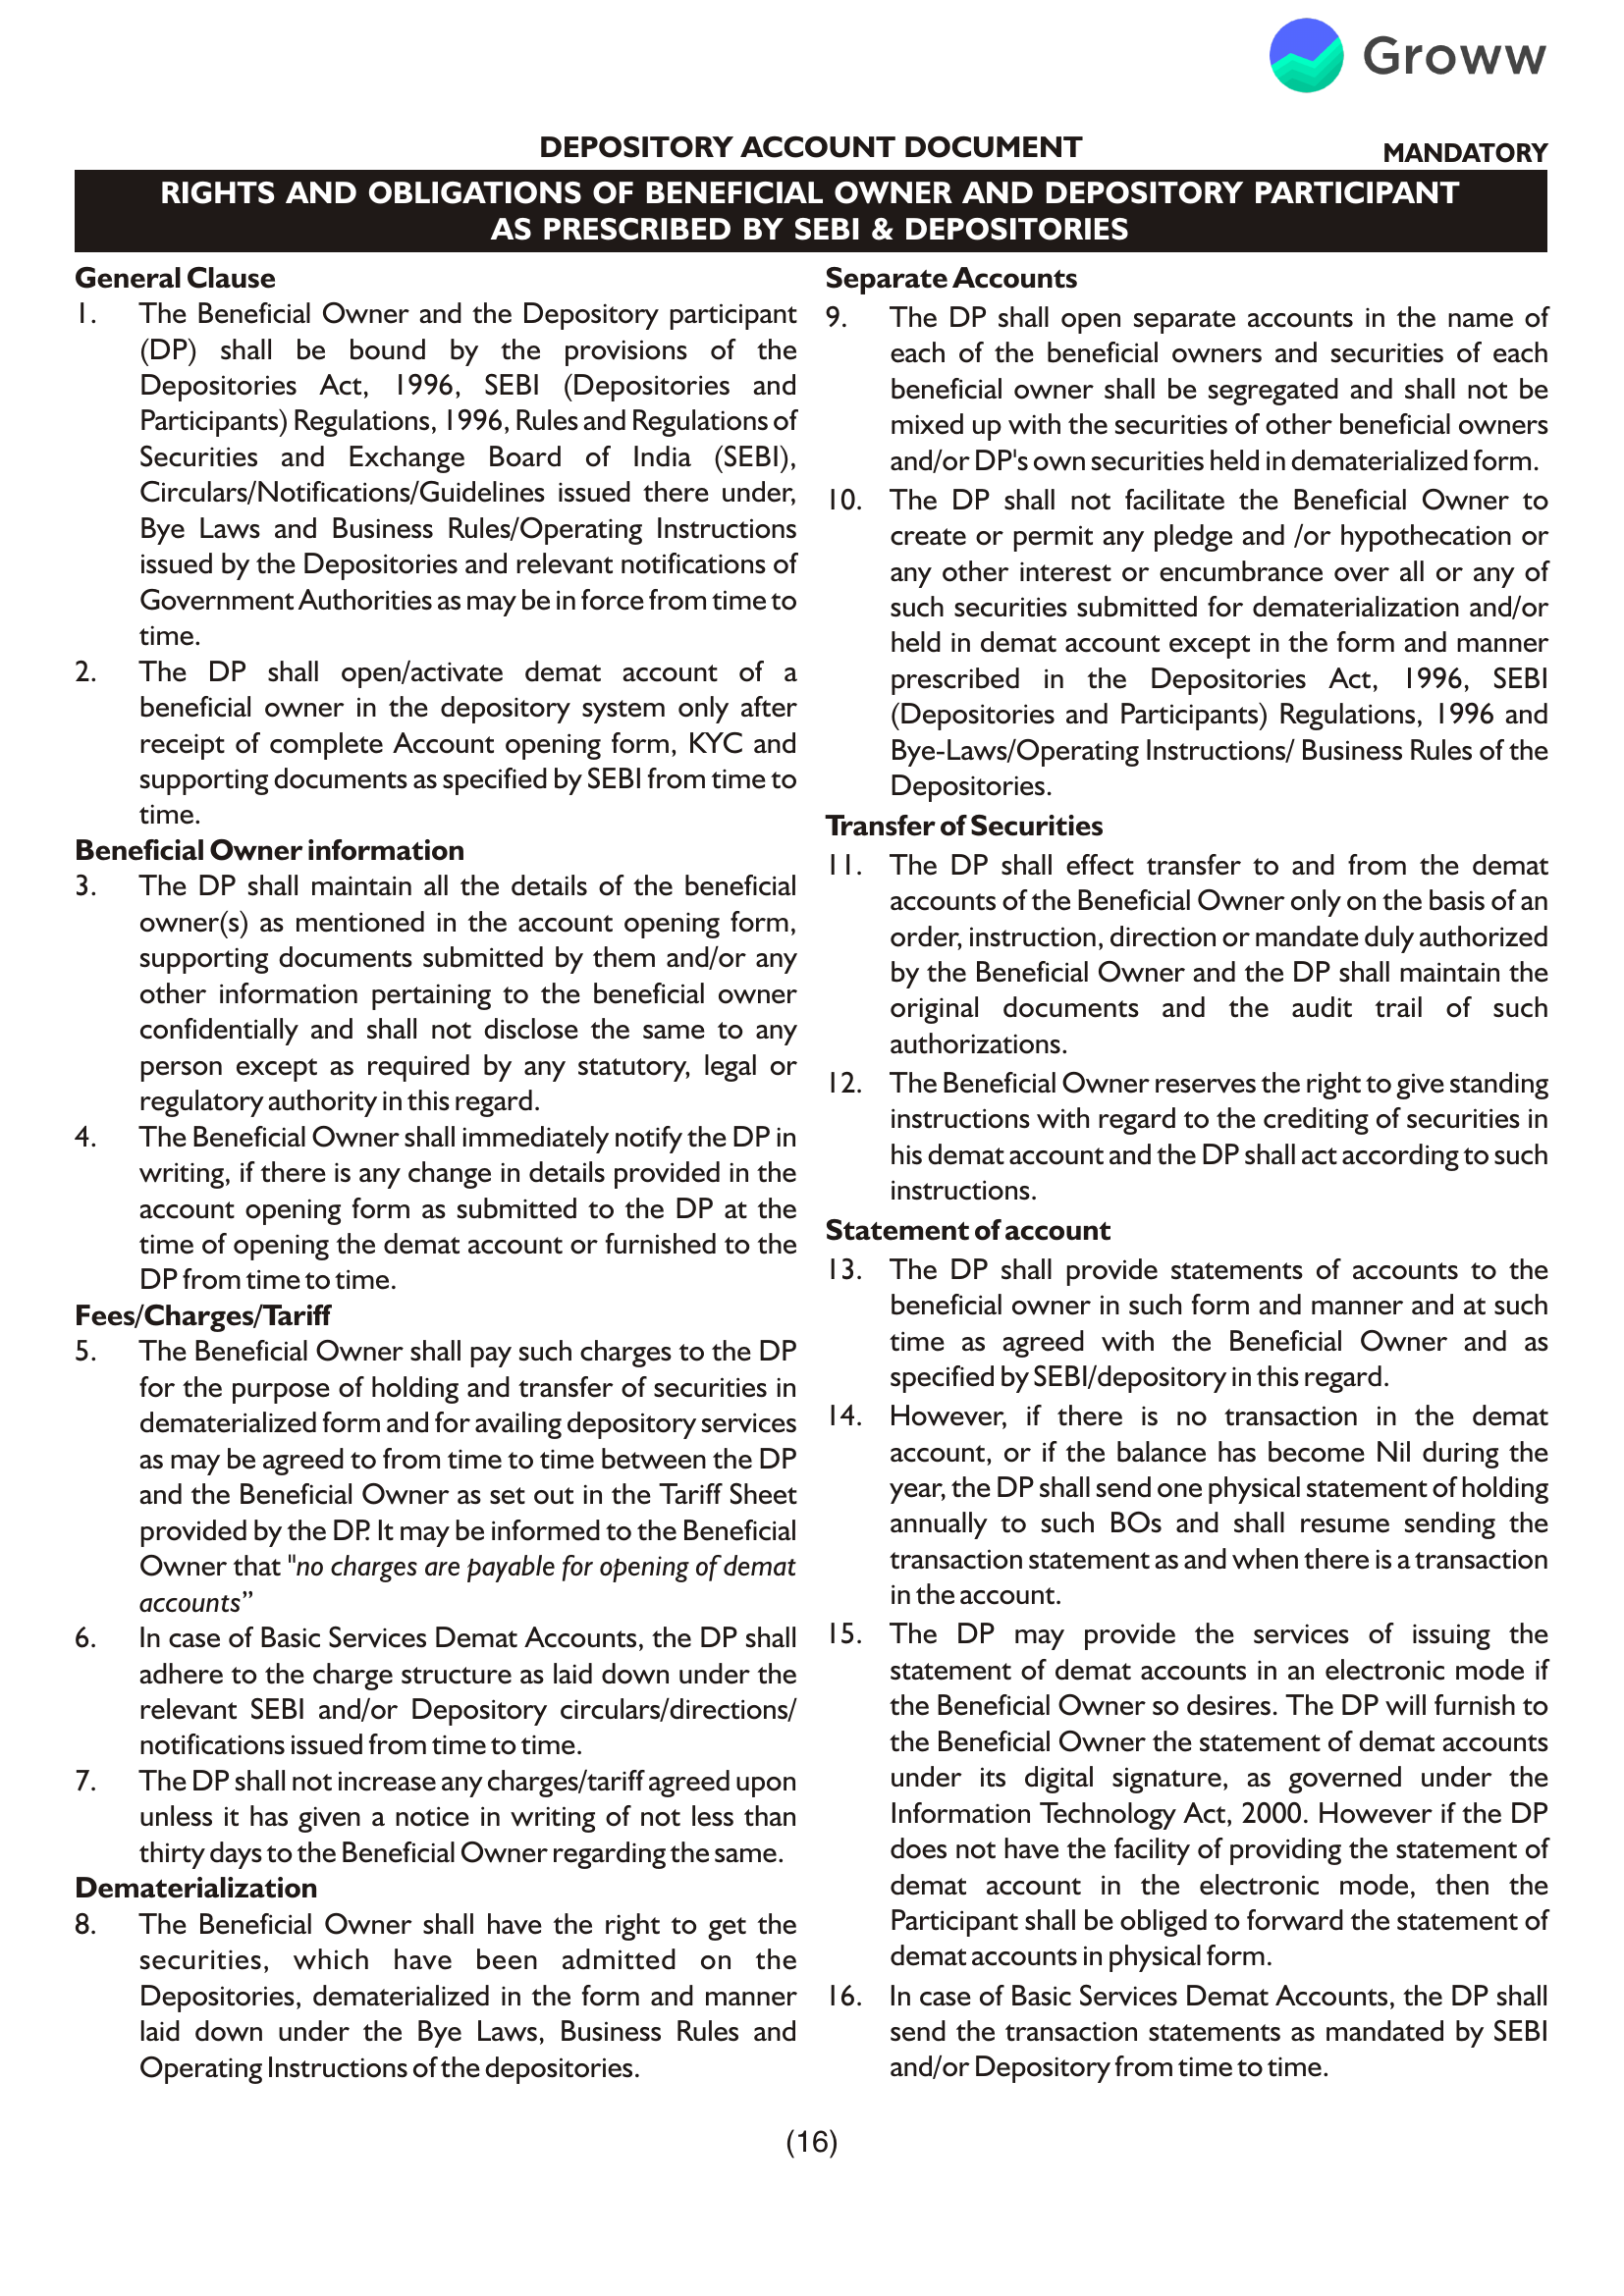


Query: General
Top 3 results:
Rank 1: Document: /content/groww-client-guidance.pdf, Page: 4, Distance: 0.0375, Metadata: {'document_name': '/content/groww-client-guidance.pdf', 'page_number': 8}


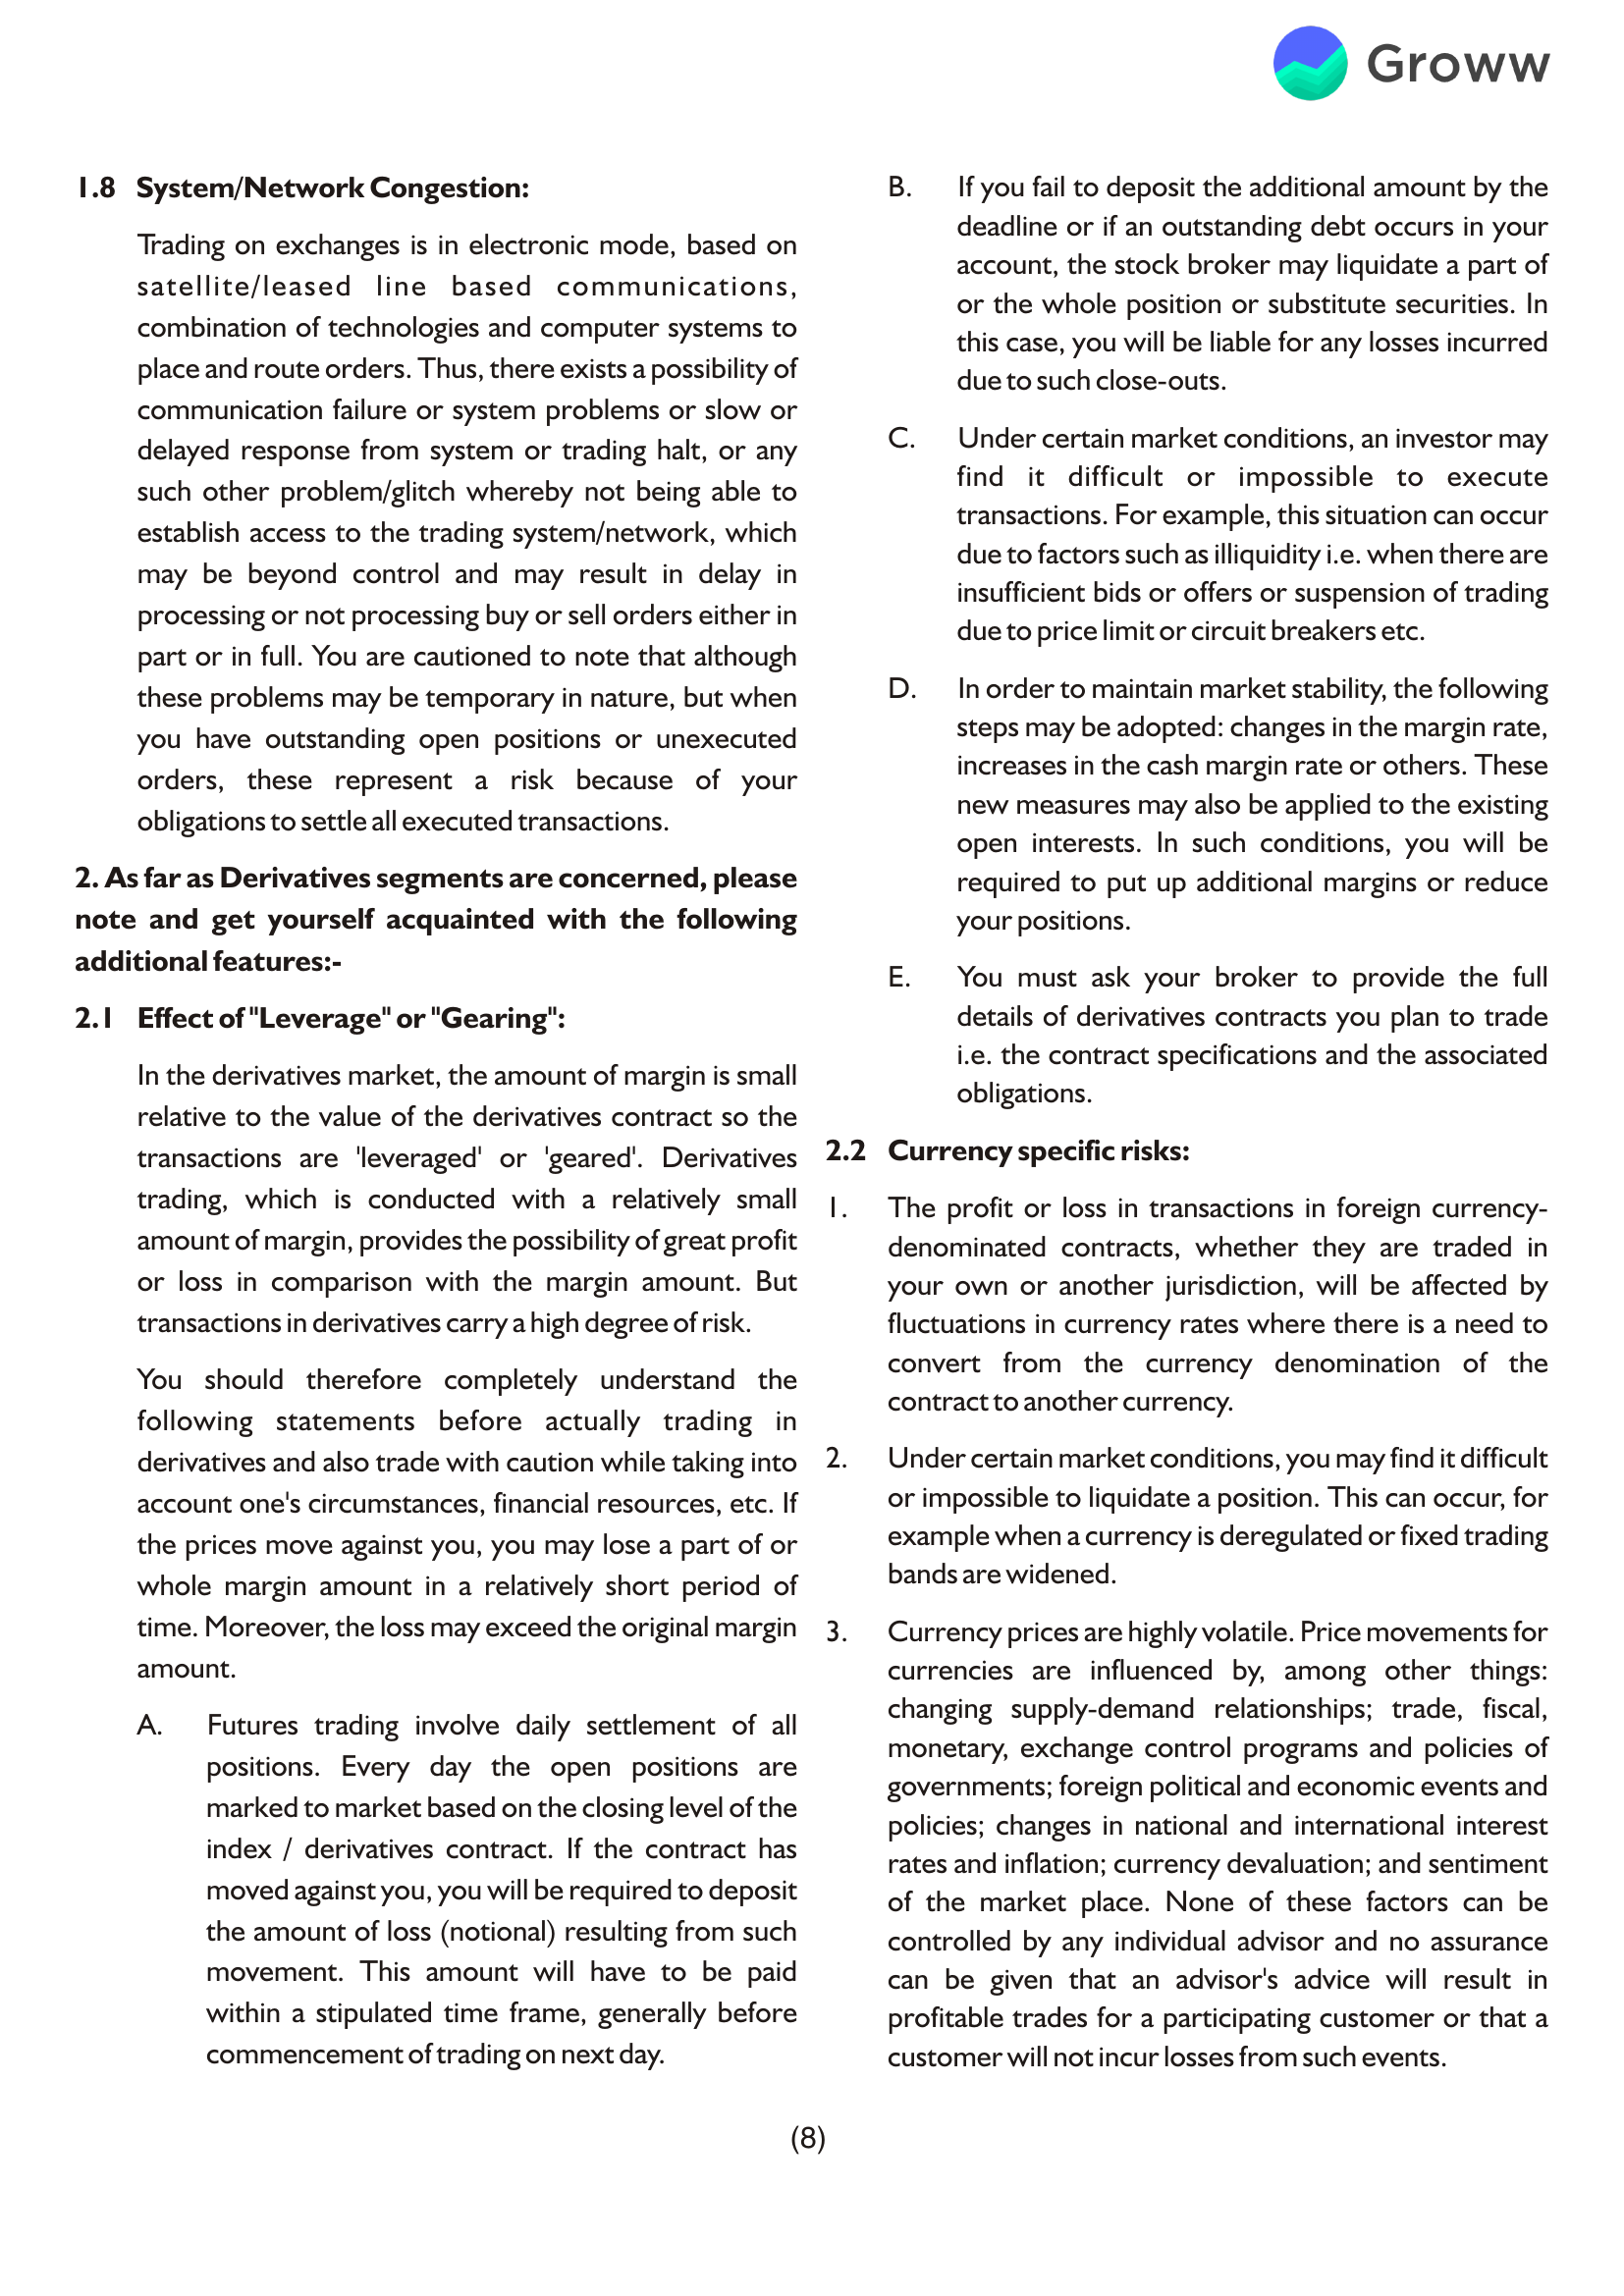

Rank 2: Document: /content/groww-client-guidance.pdf, Page: 2, Distance: 0.0379, Metadata: {'document_name': '/content/groww-client-guidance.pdf', 'page_number': 6}


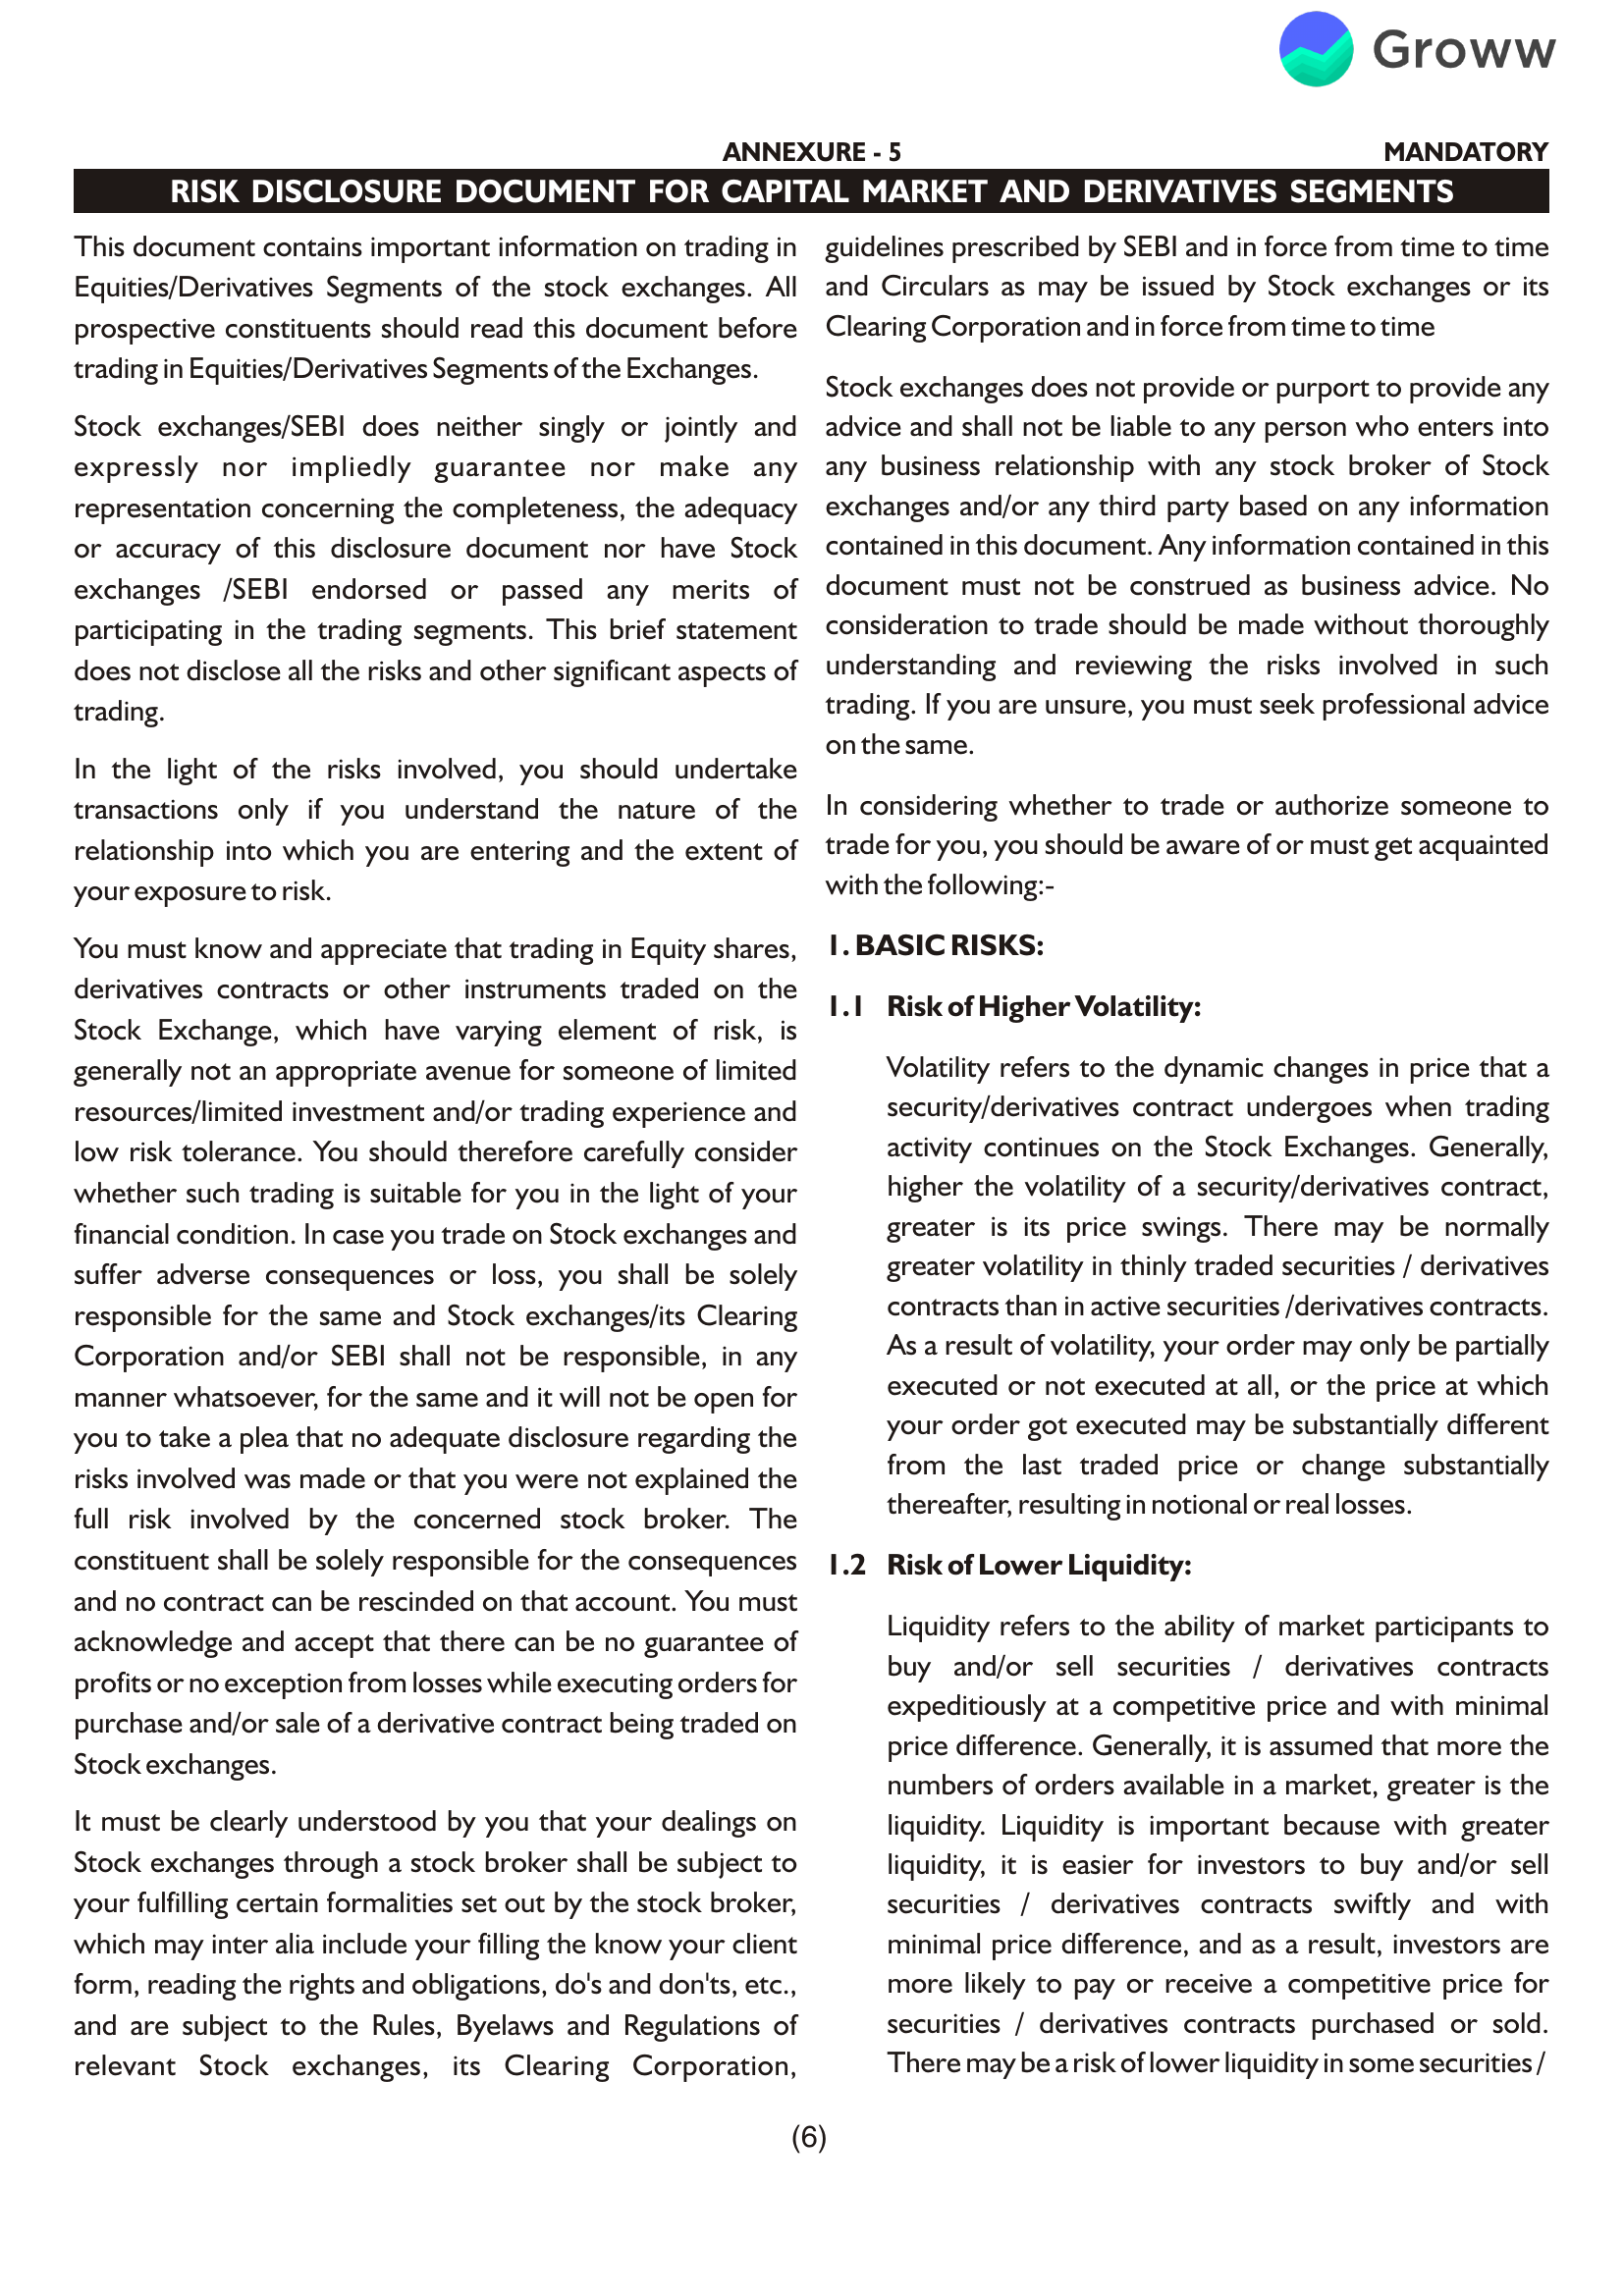

Rank 3: Document: /content/groww-client-guidance.pdf, Page: 1, Distance: 0.0388, Metadata: {'document_name': '/content/groww-client-guidance.pdf', 'page_number': 1}


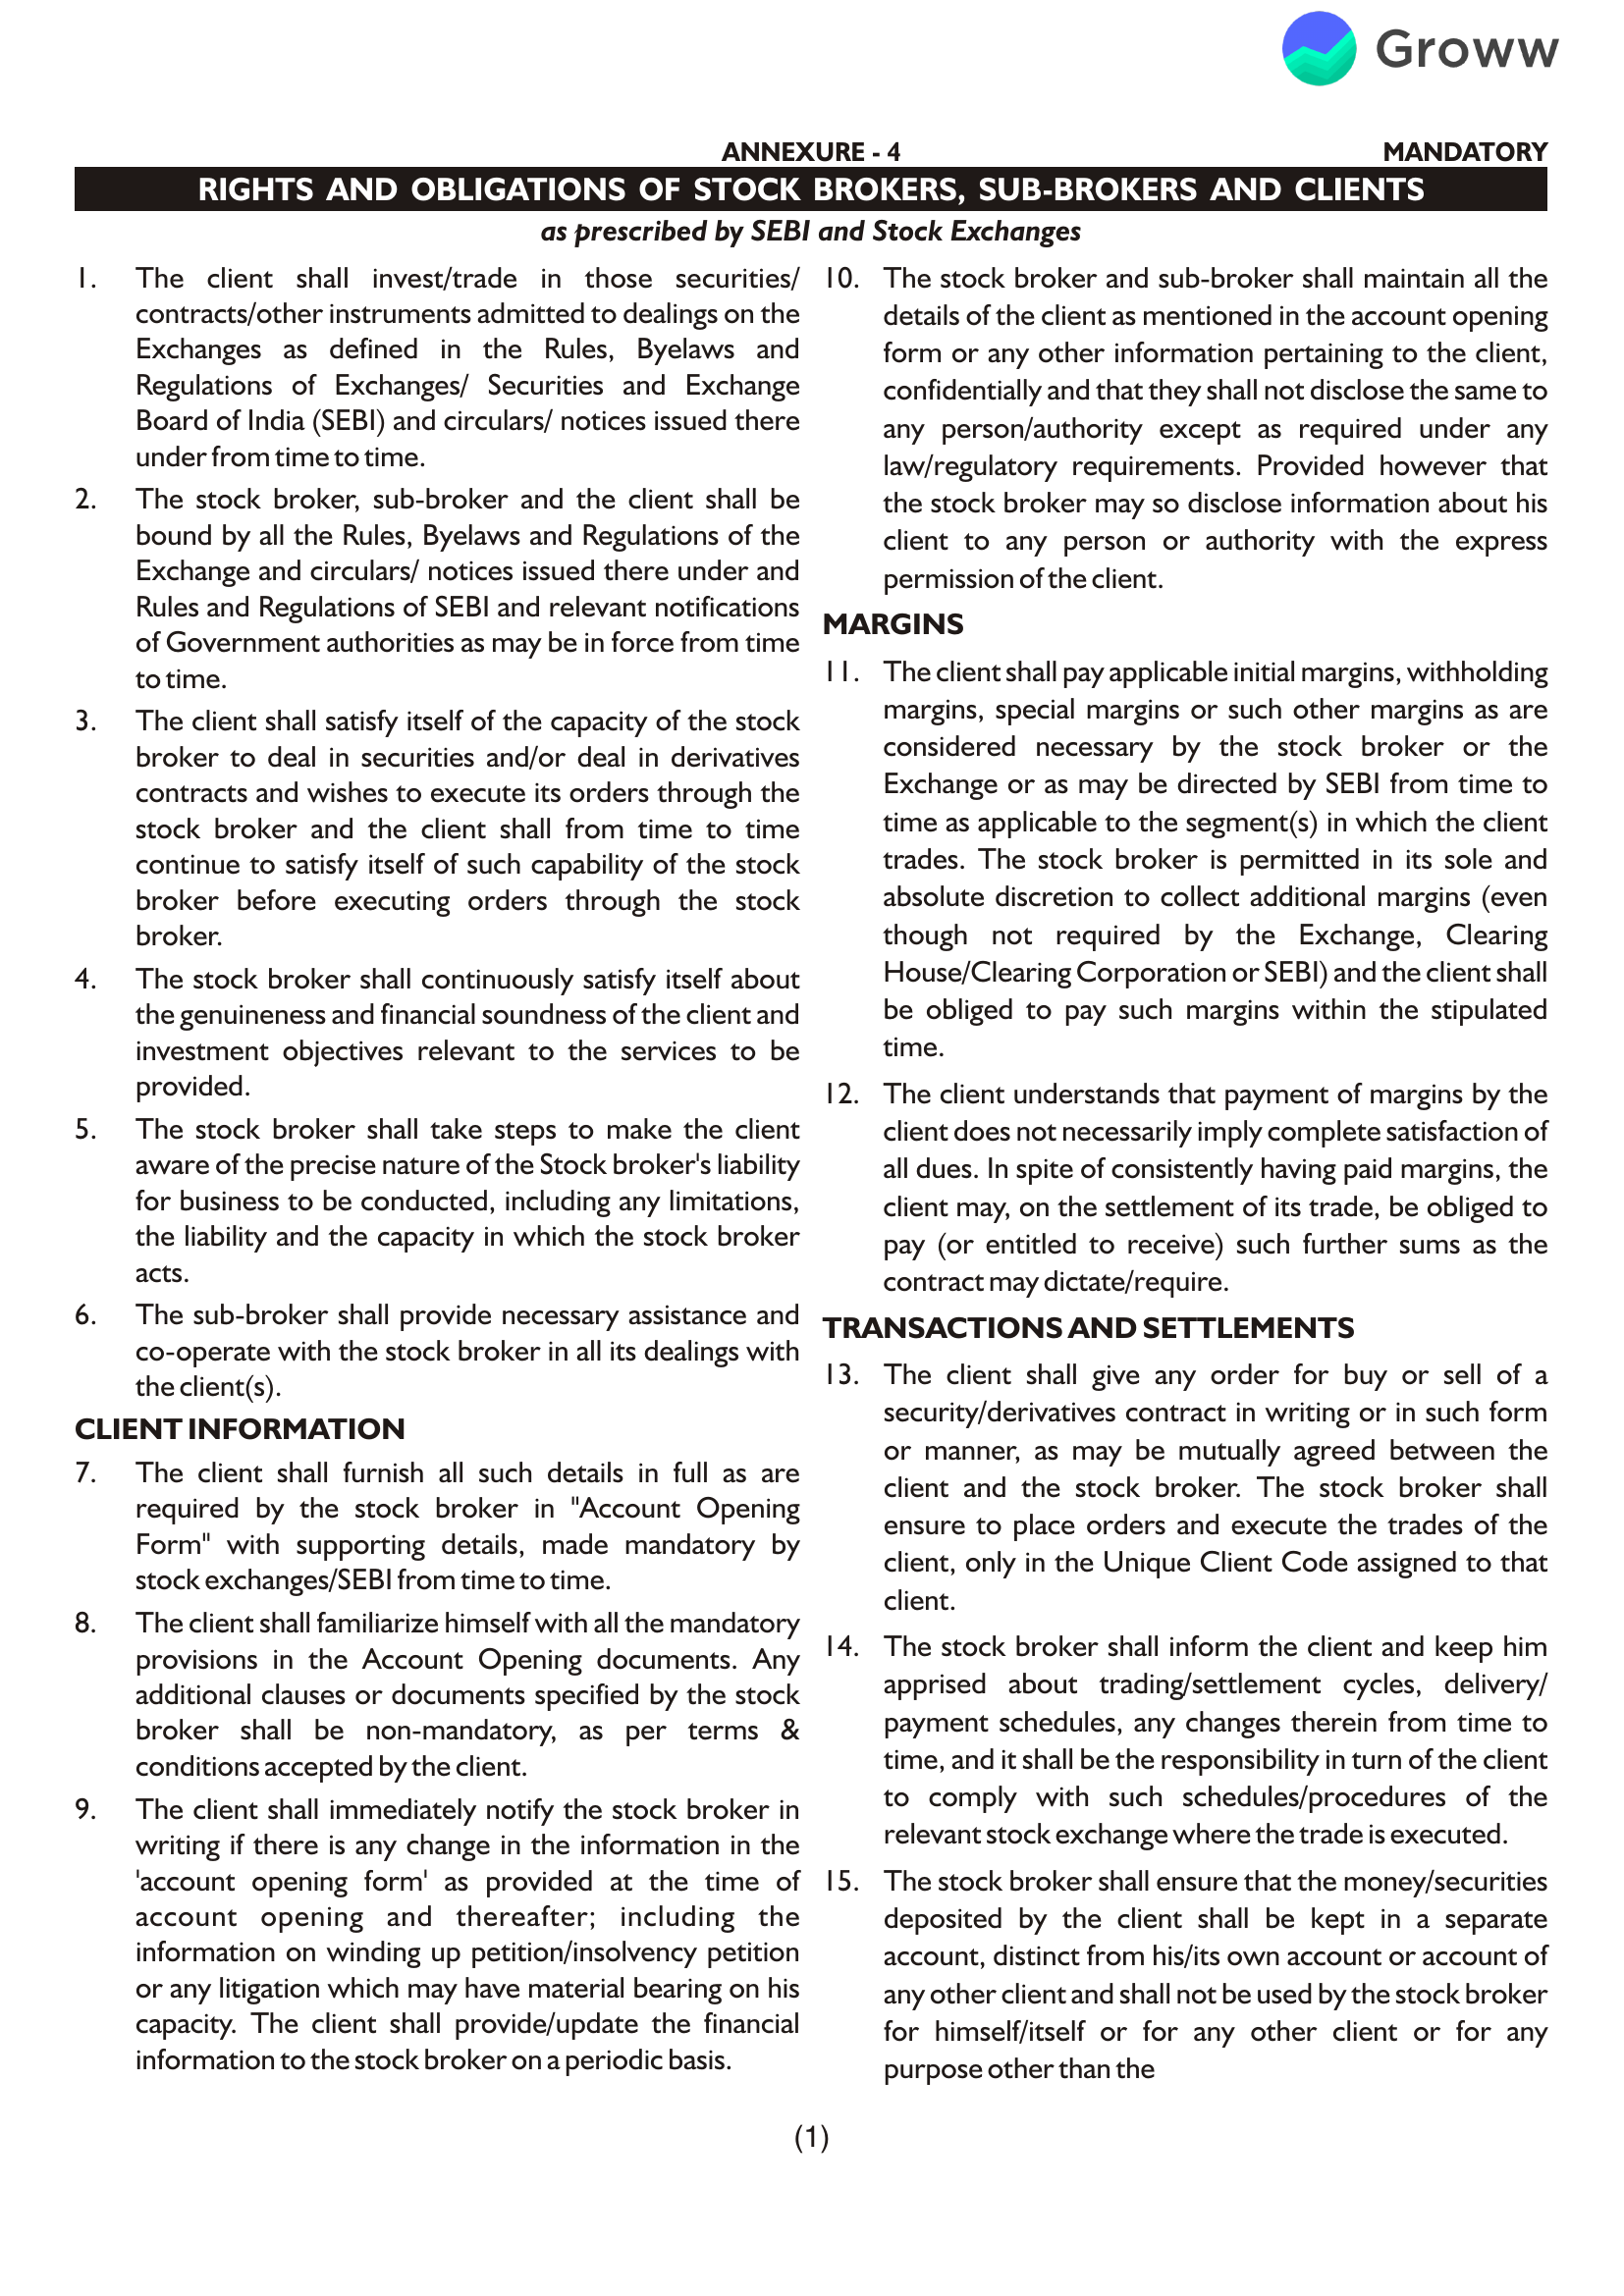

In [55]:
queries = ["in case of termination of trading membership","General"]

# Perform search and show document names with page information
search(model, processor, documents_with_filenames, queries, top_k=3)

In [ ]:
queries = ["Frozen Food","XYZ CONSULTING FIRM","Groceries","SOPHIE WRIGHT","Sally Branders"]

In [ ]:
search_documents(model, processor, documents_with_filenames, queries, top_k=3)

100%|██████████| 1/1 [00:09<00:00,  9.67s/it]


tensor([1, 1, 0, 1, 1])
Top 1 Accuracy (verif): 0.2

Query: Frozen Food
Top 3 results:
Document: /content/sample_receipt.png - Score: 15.0625
Document: /content/job-resume-template-259-350x495.png - Score: 15.0
Document: /content/sample_bill.png - Score: 15.0

Query: XYZ CONSULTING FIRM
Top 3 results:
Document: /content/sample_receipt.png - Score: 17.0
Document: /content/job-resume-template-259-350x495.png - Score: 16.875
Document: /content/new-york-resume-templates.png - Score: 16.875

Query: Groceries
Top 3 results:
Document: /content/job-resume-template-259-350x495.png - Score: 14.875
Document: /content/new-york-resume-templates.png - Score: 14.875
Document: /content/sample_receipt.png - Score: 14.875

Query: SOPHIE WRIGHT
Top 3 results:
Document: /content/job-resume-template-259-350x495.png - Score: 16.75
Document: /content/sample_receipt.png - Score: 16.75
Document: /content/new-york-resume-templates.png - Score: 16.625

Query: Sally Branders
Top 3 results:
Document: /content/samp

#  Byaldi

In [ ]:
!git clone https://github.com/AnswerDotAI/byaldi.git

Cloning into 'byaldi'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 148 (delta 74), reused 120 (delta 54), pack-reused 0 (from 0)
Receiving objects: 100% (148/148), 1.97 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [ ]:
%cd byaldi

/content/byaldi


In [ ]:
!pip install -e "."

Obtaining file:///content/byaldi
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 24.7 MB/s eta 0:00:00
  Building editable for Byaldi (pyproject.toml) ... done
  Created wheel for Byaldi: filename=Byaldi-0.0.2.post2-0.editable-py3-none-any.whl size=14046 sha256=825aca9e0dcce77026cc2095332d2d898cdc6426ac118e98dd5b710b583156a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_qiyc4x_/wheels/05/35/6c/7376a3a73ed94aa60fd0bd33179ccf86b026e0b8151ba8ba6e
Successfully built Byaldi
  Attempting uninstall: mteb
    Found existing installation: mteb 1.14.15
    Uninstalling mteb-1.14.15:
      Successfully uninstalled mteb-1.14.15


In [ ]:
%cd byaldi

/content/byaldi/byaldi


In [ ]:
from byaldi.byaldi import RAGMultiModalModel

RAG = RAGMultiModalModel.from_pretrained("vidore/colpali")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [ ]:
RAG.index(
    input_path="/content/364253783.pdf",
    index_name="image_index", # index will be saved at index_root/index_name/
    store_collection_with_index=False,
    overwrite=True
)

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Index exported to .byaldi/image_index
Index exported to .byaldi/image_index


{0: '/content/364253783.pdf'}

In [ ]:
text_query = "Dr.S.Vijayalakshmi? "
results = RAG.search(text_query, k=3)
results

[{'doc_id': 0, 'page_num': 1, 'score': 19.75, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 2, 'score': 16.875, 'metadata': {}, 'base64': None},
 {'doc_id': 0, 'page_num': 6, 'score': 15.125, 'metadata': {}, 'base64': None}]